# Présentation du projet : 


## Problématique de la ville de Seattle

Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.
Votre mission

## Mission
Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

* Réaliser une courte analyse exploratoire.
* Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

## Conseils
Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes, et erreurs à éviter :

* L’objectif est de te passer des relevés de consommation annuels (attention à la fuite de données), mais rien ne t'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 

* Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

* Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.



# Ressources : 

## Les données et leur description :

Adresse des données : https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv

Site source, ville de Seattle : https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m
Site de visualisation des données : http://www.seattle.gov/energybenchmarkingmap/#seattle/2019?layer=energy_star_score&sort=energy_star_score&order=desc&lat=47.61&lng=-122.33&zoom=14

Description des variables globales : 

* data 2015 : https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m
* data 2016 : https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy
* description plus détaillée (sur 2018) : https://www.splitgraph.com/seattle-gov/2018-building-energy-benchmarking-7rac-kyay

Description de variables particulières :
* Energy star score : https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results
* 2010 Census tract : https://www.census.gov/geographies/reference-maps/2010/geo/2010-census-tract-maps.html

## Sur les méthodes stat :


## Sur les outils de programmation : 


# Présentation du notebook : 




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "/home/clairegayral/Documents/openclassroom/data/P3/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P3/"

## my .py : 
from P3_preprocess import *
import missing_values_treatment
import duplicates
import univariate_analysis
import multivariate_analysis

from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.impute import KNNImputer


##### Lecture des données : 
J'ai commencé par ouvrir les deux table avec la bibliothèque pandas : 

In [2]:
df_2015 = pd.read_csv(data_path+"2015-building-energy-benchmarking.csv", 
                          low_memory=False)#, index_col=0)
df_2016 = pd.read_csv(data_path+"2016-building-energy-benchmarking.csv", 
                          low_memory=False)#, index_col=0)

print("In 2015 data :", df_2015.shape[0],
      " buildings and ", df_2015.shape[1],"variables")
print("Total NaNs = ", df_2015.isna().sum().sum(), 
      "(that is ",np.round(100*df_2015.isna().sum().sum()/(
        df_2015.shape[0]*df_2015.shape[1]),2), "%)")
print(" ")
print("In 2016 data :", df_2016.shape[0],
      " buildings and ", df_2016.shape[1],"variables")
print("Total NaNs = ", df_2016.isna().sum().sum(), 
      "(that is ",np.round(100*df_2016.isna().sum().sum()/(
        df_2016.shape[0]*df_2015.shape[1]),2), "%)")

In 2015 data : 3340  buildings and  47 variables
Total NaNs =  26512 (that is  16.89 %)
 
In 2016 data : 3376  buildings and  46 variables
Total NaNs =  19952 (that is  12.57 %)


##### Identification des variables communes 

Les deux tables de données n'ont pas les mêmes variables. Certaines variables sont communes. D'autres ont l'air de correspondre d'une table à l'autre mais n'ont pas la même nomenclature. 
C'est le cas de :
* ```Zip Codes``` dans 2015 et ```ZipCode``` dans 2016
* ```Comment``` dans 2015 et ```Comments``` dans 2016

Il y a aussi les variables de localisation, présentes sous forme de pseudo-dictionnaire dans la variable ```Location``` des données 2015, et dans les colonnes ```Address```, ```City```, ```Latitude```, ```Longitude``` et ```State``` des données 2016. Ces variables ne me semblent pas pertinentes pour la suite de l'étude, car il y a une variable catégorielle ```Neighborhood```qui me semble être un proxi largement suffisant, et beaucoup plus simple à manier. 

De la même manière, j'ai choisi de supprimer la varible ```2010 Census Tracts``` de la table de 2015, car c'est une variable de localisation, et elle est très creuse (93.3% de valeurs manquantes)

In [3]:
### rename similar columns in 2015 as in 2016 data
df_2015 = df_2015.rename(columns={"Zip Codes":"ZipCode",
                                 "Comment":"Comments"})
### Location column split to extract longitude and latitude
print(df_2015["Location"][0].split(","))

### remove non-pertinent columns : 
df_2015 = df_2015.drop(["Location", '2010 Census Tracts', 'City Council Districts'], axis=1)
df_2016 = df_2016.drop(['Address', 'City', 'Latitude', 'Longitude', 'State'],axis=1)

["{'latitude': '47.61219025'", " 'longitude': '-122.33799744'", ' \'human_address\': \'{"address": "405 OLIVE WAY"', ' "city": "SEATTLE"', ' "state": "WA"', ' "zip": "98101"}\'}']


In [4]:
tmp2015 = np.sort(df_2015.columns)
tmp2016 = np.sort(df_2016.columns)

tmp2015 = tmp2015[[var not in df_2016.columns.values for var in tmp2015]]
tmp2016 = tmp2016[[var not in df_2015.columns.values for var in tmp2016]]
tmp_both = df_2015.columns.intersection(df_2016.columns)
## affichage que dans 2015 
print("Les variables qui ne sont que dans les données 2015 : ")
for var in tmp2015 : print("\t",var, ": ", 
                           np.round(100*df_2015[var].isna().sum() / df_2015.shape[0],1), "% NaNs" )
## affichage que dans 2016 
print("\nLes variables qui ne sont que dans les données 2016 : ")
for var in tmp2016 : print("\t",var, ": ", 
                           100*np.round(df_2016[var].isna().sum() / df_2016.shape[0],1), "% NaNs" )
## affichage variables communes :
print("\nLes variables communes aux données 2015 et 2016 : ")
for var in tmp_both : 
    percent_nans =100* (df_2015[var].isna().sum() / df_2015.shape[0] 
                    + df_2016[var].isna().sum() / df_2016.shape[0])/2
    print("\t",var,": ", np.round(percent_nans,1), "% NaNs" )


Les variables qui ne sont que dans les données 2015 : 
	 GHGEmissions(MetricTonsCO2e) :  0.3 % NaNs
	 GHGEmissionsIntensity(kgCO2e/ft2) :  0.3 % NaNs
	 OtherFuelUse(kBtu) :  0.3 % NaNs
	 SPD Beats :  0.1 % NaNs
	 Seattle Police Department Micro Community Policing Plan Areas :  0.1 % NaNs

Les variables qui ne sont que dans les données 2016 : 
	 GHGEmissionsIntensity :  0.0 % NaNs
	 TotalGHGEmissions :  0.0 % NaNs

Les variables communes aux données 2015 et 2016 : 
	 OSEBuildingID :  0.0 % NaNs
	 DataYear :  0.0 % NaNs
	 BuildingType :  0.0 % NaNs
	 PrimaryPropertyType :  0.0 % NaNs
	 PropertyName :  0.0 % NaNs
	 TaxParcelIdentificationNumber :  0.0 % NaNs
	 CouncilDistrictCode :  0.0 % NaNs
	 Neighborhood :  0.0 % NaNs
	 YearBuilt :  0.0 % NaNs
	 NumberofBuildings :  0.1 % NaNs
	 NumberofFloors :  0.1 % NaNs
	 PropertyGFATotal :  0.0 % NaNs
	 PropertyGFAParking :  0.0 % NaNs
	 PropertyGFABuilding(s) :  0.0 % NaNs
	 ListOfAllPropertyUseTypes :  2.0 % NaNs
	 LargestPropertyUseType :  2.3

D'autres variables ont l'air d'avoir un lien fort ```GHGEmissions(MetricTonsCO2e)``` et ```TotalGHGEmissions```. Néanmoins, sachant que le taux CO2 est une des deux variables à prédire, il me paraît nécessaire de ne pas les fusionner avant d'avoir vérifier qu'il n'y avait pas un biais entre les deux. D'après [ce site](https://www.epa.gov/ghgemissions/overview-greenhouse-gases) les émissions de CO2 représentent 80% des émissions de gaz à effet de serre (GHG pour "Green House Gases" en anglais). Vérifions s'il est possible de corriger le biais d'avoir une mesure sur tous les GHG sur la table 2016 :


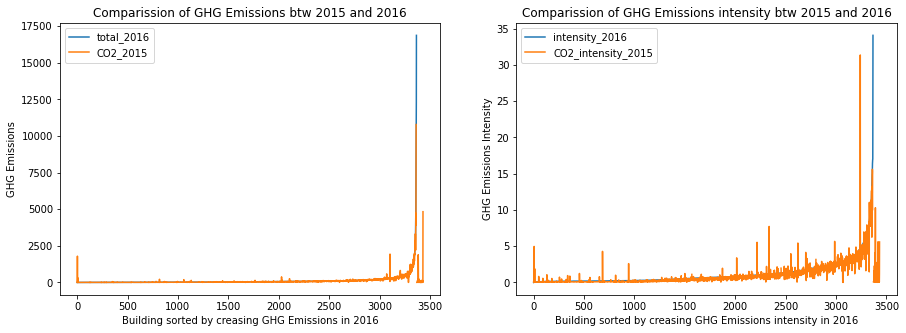

In [5]:
GHG_emissions = pd.merge(
    df_2016[["OSEBuildingID","TotalGHGEmissions","GHGEmissionsIntensity"]], 
    df_2015[["OSEBuildingID", "GHGEmissions(MetricTonsCO2e)","GHGEmissionsIntensity(kgCO2e/ft2)"]], 
    on ="OSEBuildingID" , how = 'outer', suffixes=('', '_2015')).copy()
GHG_emissions = GHG_emissions.rename(columns={"TotalGHGEmissions": "total_2016", 
                                              "GHGEmissionsIntensity":"intensity_2016",
                                              "GHGEmissions(MetricTonsCO2e)":"CO2_2015" ,
                                              "GHGEmissionsIntensity(kgCO2e/ft2)":"CO2_intensity_2015"})
fig = plt.figure(figsize=(15,5))
## plot to compare GHG emission and CO2 emission :
ax = fig.add_subplot(1,2,1)
GHG_emissions = GHG_emissions.sort_values(by = "total_2016", axis = 0 )
ax.plot(range(GHG_emissions.shape[0]), GHG_emissions[["total_2016","CO2_2015"]] )
ax.set_title("Comparission of GHG Emissions btw 2015 and 2016")
ax.set_xlabel("Building sorted by creasing GHG Emissions in 2016")
ax.set_ylabel("GHG Emissions")
ax.legend(["total_2016","CO2_2015"])
## plot to compare intensity of emission
GHG_emissions = GHG_emissions.sort_values(by = "intensity_2016", axis = 0)
ax = fig.add_subplot(1,2,2)
ax.plot(range(GHG_emissions.shape[0]), GHG_emissions[["intensity_2016","CO2_intensity_2015"]] )
ax.set_title("Comparission of GHG Emissions intensity btw 2015 and 2016")
ax.set_xlabel("Building sorted by creasing GHG Emissions intensity in 2016")
ax.set_ylabel("GHG Emissions Intensity")
ax.legend(["intensity_2016","CO2_intensity_2015"])
plt.show()

Il ne semble pas y avoir de biais entre ces deux mesures : je choisis donc de les fusionner, sous le nom commun de respectivement ```CO2_emissions``` et ```CO2_emissions_intensity``` : 

In [6]:
df_2016 = df_2016.rename(columns={"TotalGHGEmissions": "CO2_emissions", 
                                  "GHGEmissionsIntensity":"CO2_emissions_intensity"})
df_2015 = df_2015.rename(columns={"GHGEmissions(MetricTonsCO2e)":"CO2_emissions" ,
                                  "GHGEmissionsIntensity(kgCO2e/ft2)":"CO2_emissions_intensity"})
tmp2015 = np.sort(df_2015.columns)
tmp2016 = np.sort(df_2016.columns)
tmp2015 = tmp2015[[var not in df_2016.columns.values for var in tmp2015]]
tmp2016 = tmp2016[[var not in df_2015.columns.values for var in tmp2016]]
## affichage que dans 2015 
print("Les variables qui ne sont que dans les données 2015 : ")
for var in tmp2015 : print("\t",var, ": ", 
                           np.round(100*df_2015[var].isna().sum() / df_2015.shape[0],1), "% NaNs" )
print(df_2015[tmp2015].describe())

## affichage que dans 2016 
print("\nLes variables qui ne sont que dans les données 2016 : ")
for var in tmp2016 : print("\t",var,  ": ", 
                           np.round(100*df_2016[var].isna().sum() / df_2016.shape[0],1), "% NaNs" )
print(df_2016[tmp2016].head())

Les variables qui ne sont que dans les données 2015 : 
	 OtherFuelUse(kBtu) :  0.3 % NaNs
	 SPD Beats :  0.1 % NaNs
	 Seattle Police Department Micro Community Policing Plan Areas :  0.1 % NaNs
       OtherFuelUse(kBtu)    SPD Beats  \
count        3.330000e+03  3338.000000   
mean         7.142301e+03    24.825644   
std          1.962790e+05    15.006287   
min          0.000000e+00     1.000000   
25%          0.000000e+00    10.000000   
50%          0.000000e+00    26.000000   
75%          0.000000e+00    38.000000   
max          8.269669e+06    51.000000   

       Seattle Police Department Micro Community Policing Plan Areas  
count                                        3338.000000              
mean                                           32.380168              
std                                            19.907567              
min                                             1.000000              
25%                                            14.000000              
5

J'ai supprimé ces variables qui n'apparaissent que dans une des deux tables : 

In [7]:
df_2015 = df_2015.drop(tmp2015, axis = 1)
df_2016 = df_2016.drop(tmp2016, axis = 1)

##### Age des bâtiments 
Il me parait plus pertinent de traiter la variable ```YearBuilt``` comme variable quantitative, plutôt que comme variable catégorielle. Pour cela, je déduis 2015 (resp. 2016) à la colonne ```YearBuilt``` pour la remplacer par la nouvelle colonne ```age_of_building```

In [8]:
df_2015.at[:,"age_of_building"] = df_2015["DataYear"] - df_2015["YearBuilt"]
df_2016.at[:,"age_of_building"] = df_2016["DataYear"] - df_2016["YearBuilt"]

df_2015 = df_2015.drop(["YearBuilt","DataYear"], axis = 1)
df_2016 = df_2016.drop(["YearBuilt","DataYear"], axis = 1)

# Data merge : 

I decided to merge the 2016 and 2015 dataframes, taking the mean value if the building is in both.

In [9]:
data = pd.merge(df_2016, df_2015, on ="OSEBuildingID" ,
               how = 'outer', suffixes=('', '_2015'))

def my_agg_by_mean(colname):
    if colname[-5:] == "_2015":
        res = data.loc[:,[colname[:-5],colname]]
        data.at[:,colname[:-5]] = res.mean(axis=1)
        data.drop(colname, axis=1, inplace=True)
    return(data)        
    
def my_agg_filling_missing(colname) :
    if colname[-5:] == "_2015":
        res = data.loc[:,[colname[:-5],colname]]
        data.at[:,colname[:-5]] = res[colname[:-5]].fillna(colname)
        data.drop(colname, axis=1, inplace=True)
    return(data)
    
float_var = data.loc[:,data.dtypes==float].columns.values
int_var = data.loc[:,data.dtypes==int].columns.values
all_num_var = np.concatenate((float_var,int_var))

for colname in all_num_var:
    data = my_agg_by_mean(colname)
for colname in data.columns :
    data = my_agg_filling_missing(colname)


Changement des types en adéquation avec l'exploration (présentée après) : 

In [10]:
# data[["BuildingType","PrimaryPropertyType","Neighborhood","ComplianceStatus"]] = data[["BuildingType","PrimaryPropertyType","Neighborhood","ComplianceStatus"]].astype("category")
categorical_var_in_data = np.sort(data.columns.intersection(categorical_var))
data[categorical_var_in_data] = data[categorical_var_in_data].astype("category")
# data= data.astype({var :"category" for var in categorical_var_in_data})

numerical_var_in_data = data.columns.intersection(numerical_var)

In [11]:
# ##TODO : je ne sais pas si je garde cette répartition : 
# float_var = data.loc[:,data.dtypes==float].columns.values
# int_var = data.loc[:,data.dtypes==int].columns.values
# all_num_var = np.concatenate((float_var,int_var))

# all_num_var

# Variable type : 

Tout d'abord, il est essentiel de savoir quelle variable est pertinente pour mon étude. J'ai utilisé l'histogramme graphique ou le graphique trié de la série de variables, et je l'ai comparé à [la page originale du site Web de Seattle] (https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m) pour déterminer le type de chaque variable. Cela m'a permis de séparer les variables numériques, catégorielles et d'identification : 

*First of all, it is essential to know what variable is relevant for my study. I used the graphical histogram or sorted plot of the variable serie, and I compared that to [the original page on Seattle data website](https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m) to determine what type each variable is. It allowed me to separate numerical, categorical and identification variable :*

array([1. , 2. , 2.5, 3. , 4. , 5. , 5.5, 6. , 7. ])

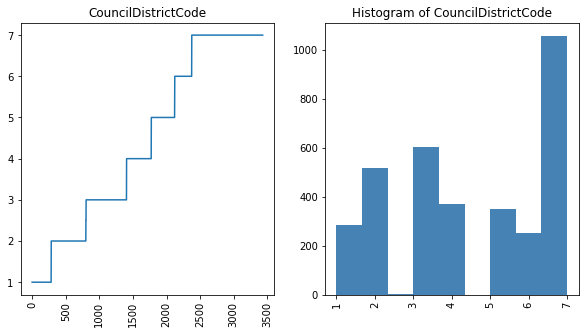

In [12]:
var = "CouncilDistrictCode"
univariate_analysis.repartition_and_hist(data,var)
np.unique(data[var])

### Etude grossière des variables descriptives numériques

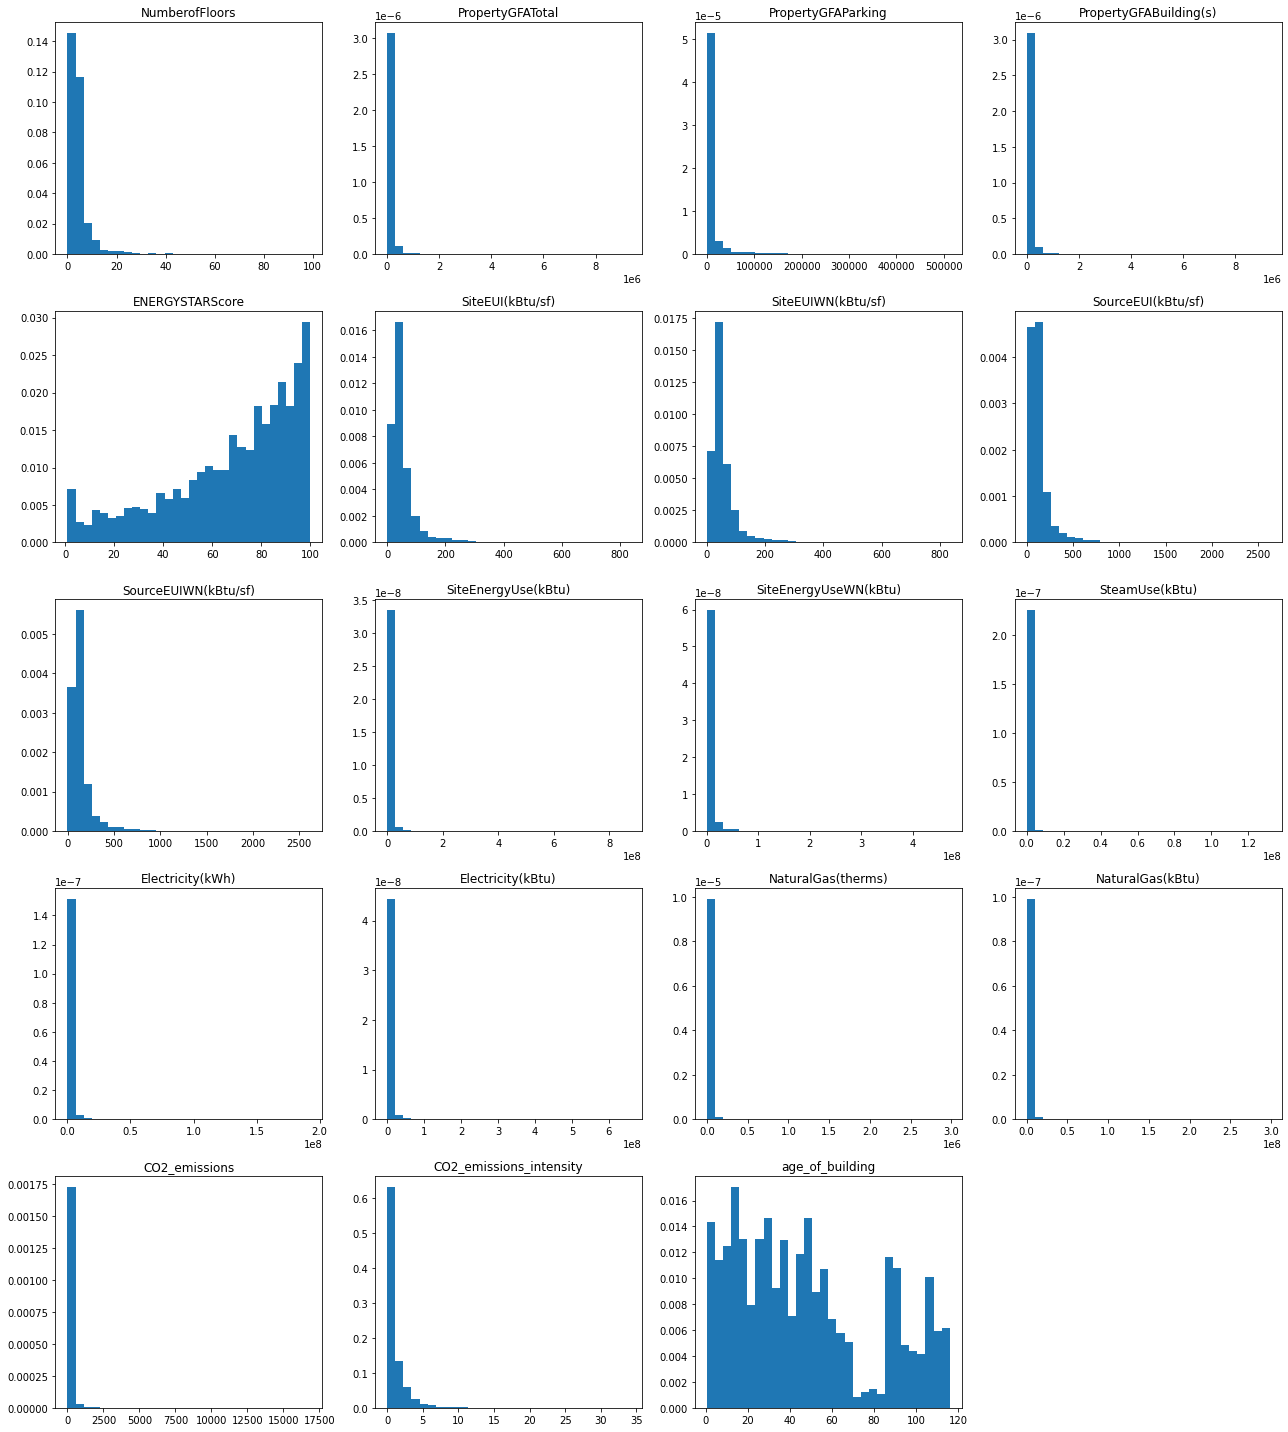

In [13]:
univariate_analysis.plot_multi_hist(data, numerical_var_in_data)

In [14]:
data[numerical_var_in_data].describe()

,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),CO2_emissions,CO2_emissions_intensity,age_of_building
count,3432.000000,3.432000e+03,3432.000000,3.432000e+03,2656.000000,3429.000000,3429.000000,3428.000000,3428.000000,3.429000e+03,3.429000e+03,3.428000e+03,3.428000e+03,3.428000e+03,3.428000e+03,3.428000e+03,3428.000000,3428.000000,3432.000000
mean,4.688228,9.447183e+04,9651.224068,8.482061e+04,68.116717,54.445859,57.489341,133.943174,138.589950,5.398222e+06,5.311222e+06,2.737963e+05,1.087418e+06,3.710342e+06,1.361560e+04,1.361560e+06,119.311982,1.092922,47.145105
std,5.458473,2.172062e+05,32953.838541,2.048840e+05,26.377049,55.895447,57.157732,137.744473,137.275549,2.152855e+07,1.595773e+07,3.795683e+06,4.332754e+06,1.478348e+07,6.729292e+04,6.729292e+06,534.287074,1.769338,33.169116
min,0.000000,1.128500e+04,-1.500000,-8.451000e+03,1.000000,0.000000,0.000000,0.000000,-2.050000,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,0.090000,0.000000,0.500000
25%,2.000000,2.846350e+04,0.000000,2.726825e+04,52.500000,27.850000,29.600000,74.287500,79.500000,9.293272e+05,9.898913e+05,0.000000e+00,1.859820e+05,6.345736e+05,0.000000e+00,0.000000e+00,9.568750,0.150000,18.500000
50%,4.000000,4.419500e+04,0.000000,4.213725e+04,75.500000,38.100001,40.650001,95.900000,101.599999,1.792235e+06,1.940694e+06,0.000000e+00,3.440100e+05,1.173787e+06,3.211758e+03,3.211605e+05,33.842500,0.545000,41.500000
75%,5.000000,9.044875e+04,2890.250000,8.192375e+04,89.625000,60.050000,64.750001,144.150000,149.900002,4.195498e+06,4.402542e+06,0.000000e+00,8.214296e+05,2.802775e+06,1.152796e+04,1.152789e+06,91.890000,1.290000,67.500000
max,99.000000,9.320156e+06,512608.000000,9.320156e+06,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.314066e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,16870.980000,34.090000,116.000000


Il n'a pas l'air d'y avoir de valeurs aberrantes dans ces données, je passe donc ce prétraitement.

### Etude des variables descriptives catégorielles

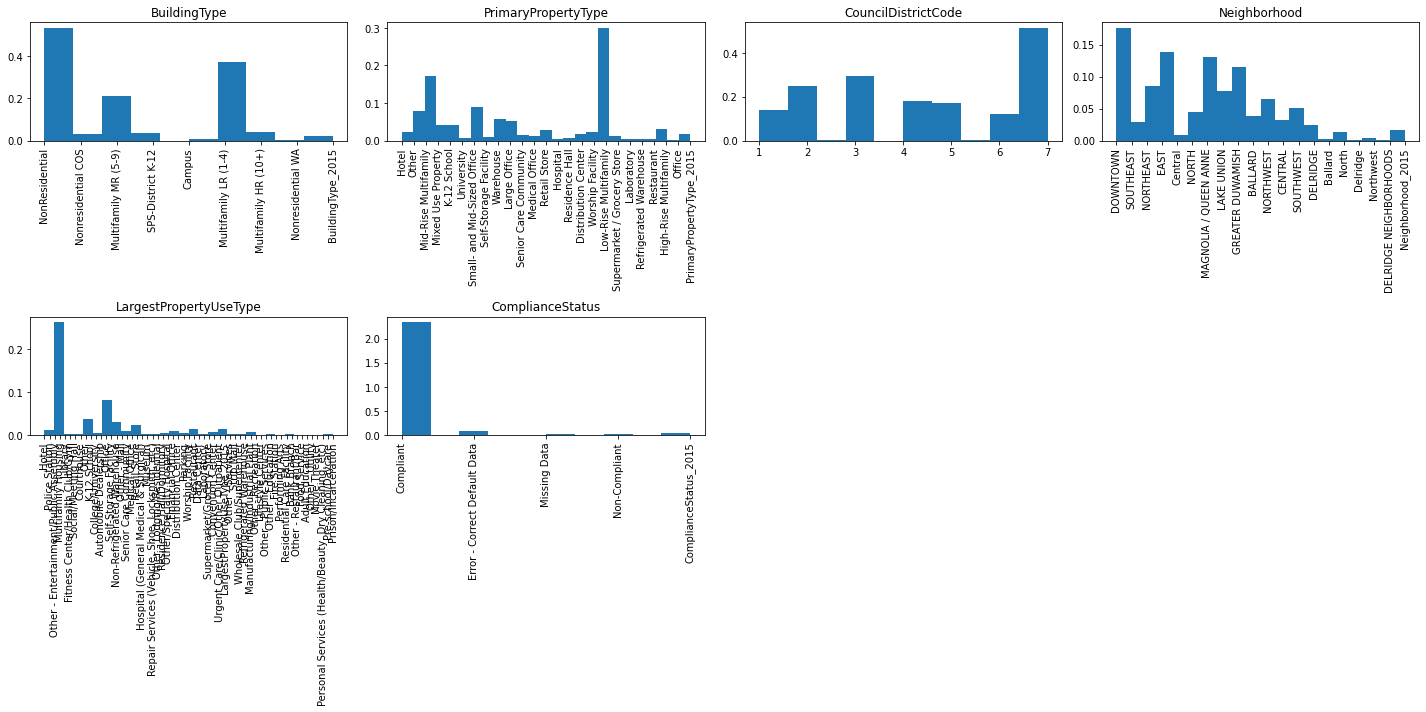

In [15]:
univariate_analysis.plot_multi_hist(data, categorical_var_in_data, figsize=(20,10))

In [16]:
data[categorical_var_in_data].describe()

,BuildingType,ComplianceStatus,CouncilDistrictCode,LargestPropertyUseType,Neighborhood,PrimaryPropertyType
count,3432,3432,3432.0,3432,3432,3432
unique,9,5,9.0,57,20,25
top,NonResidential,Compliant,7.0,Multifamily Housing,DOWNTOWN,Low-Rise Multifamily
freq,1460,3211,1057.0,1667,573,987


## Prétraitements 

##### Gestion des types :
Les types semblent corrects (vérifiés avec df.dtypes). 

In [17]:
print(data.info())
data[data.columns[data.dtypes=="object"]].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3432 entries, 0 to 3431
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   OSEBuildingID                    3432 non-null   int64   
 1   BuildingType                     3432 non-null   category
 2   PrimaryPropertyType              3432 non-null   category
 3   PropertyName                     3432 non-null   object  
 4   ZipCode                          3416 non-null   float64 
 5   TaxParcelIdentificationNumber    3432 non-null   object  
 6   CouncilDistrictCode              3432 non-null   category
 7   Neighborhood                     3432 non-null   category
 8   NumberofBuildings                3431 non-null   float64 
 9   NumberofFloors                   3432 non-null   float64 
 10  PropertyGFATotal                 3432 non-null   float64 
 11  PropertyGFAParking               3432 non-null   float64 
 12  Proper

,PropertyName,TaxParcelIdentificationNumber,ListOfAllPropertyUseTypes,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,DefaultData,Comments,Outlier
0,Mayflower park hotel,0659000030,Hotel,SecondLargestPropertyUseType_2015,ThirdLargestPropertyUseType_2015,YearsENERGYSTARCertified_2015,False,Comments_2015,Outlier_2015
1,Paramount Hotel,0659000220,"Hotel, Parking, Restaurant",Parking,Restaurant,YearsENERGYSTARCertified_2015,False,Comments_2015,Outlier_2015
2,5673-The Westin Seattle,0659000475,Hotel,SecondLargestPropertyUseType_2015,ThirdLargestPropertyUseType_2015,YearsENERGYSTARCertified_2015,False,Comments_2015,Outlier_2015
3,HOTEL MAX,0659000640,Hotel,SecondLargestPropertyUseType_2015,ThirdLargestPropertyUseType_2015,YearsENERGYSTARCertified_2015,False,Comments_2015,Outlier_2015
4,WARWICK SEATTLE HOTEL (ID8),0659000970,"Hotel, Parking, Swimming Pool",Parking,Swimming Pool,YearsENERGYSTARCertified_2015,False,Comments_2015,Outlier_2015


Et j'ai supprimé les variables qui n'étaient ni catégorielles, ni numériques : 

In [18]:
data = data.drop(data.columns[data.dtypes=="object"], axis=1)

#####  Suppression colonnes vides :

In [19]:
# var_in_data = data.columns.intersection(all_num_var)
# # num_data = data.loc[:,num_var_in_data]#.set_index(data["OSEBuildingID"])

##
## drop empty columns
##

nan_repartition = data.isna().sum(axis=0)
# nan_threshold = nan_repartition.mean()
nan_threshold = nan_repartition.quantile(0.95)
new_data = data.drop(data.columns[nan_repartition>nan_threshold], axis = 1)

print("I drop variables with less than", 
      data.shape[0]-np.floor(nan_threshold),
      "values")
print("That is more than", np.floor(nan_threshold), "missing values")
print("I have dropped", data.shape[1] - new_data.shape[1], "variables :",
      data.columns[[var not in new_data.columns for var in data.columns]])

data = new_data

I drop variables with less than 2180.0 values
That is more than 1252.0 missing values
I have dropped 2 variables : Index(['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'], dtype='object')


In [20]:
# ## 
# ## drop columns with no variation :
# ##

# data.var()

##### Gestion des doublons :

In [22]:
## mise à jour des lists de variables : 
categorical_var_in_data = data.columns.intersection(categorical_var)
num_var_in_data = data.columns.intersection(all_num_var)

## est ce qu'il y a des doublons ?
dict_duplicates = duplicates.get_index_merge_duplicates(data, num_var_in_data, 1.15)
print(dict_duplicates)

{}


##### Inférence valeurs manquantes : 

In [23]:
X_var = numerical_var_in_data[[var not in ["CO2_emissions",
                             "SiteEnergyUse(kBtu)","ENERGYSTARScore"] for var in numerical_var_in_data]]
X = data[data.columns.intersection(float_var)]#.set_index(data["OSEBuildingID"])
y = data[["OSEBuildingID", "CO2_emissions","SiteEnergyUse(kBtu)"]]#.reindex(data["OSEBuildingID"])


MSE = 154.083 (+/-37.478) for {'n_neighbors': 1}
MSE = 140.025 (+/-43.065) for {'n_neighbors': 2}
MSE = 135.817 (+/-42.241) for {'n_neighbors': 3}
MSE = 134.423 (+/-41.752) for {'n_neighbors': 4}
MSE = 134.132 (+/-40.908) for {'n_neighbors': 5}
MSE = 133.879 (+/-40.489) for {'n_neighbors': 6}
MSE = 133.916 (+/-40.190) for {'n_neighbors': 7}
MSE = 134.094 (+/-39.865) for {'n_neighbors': 8}
MSE = 134.070 (+/-39.599) for {'n_neighbors': 9}
MSE = 134.276 (+/-39.341) for {'n_neighbors': 10}
MSE = 133.936 (+/-39.643) for {'n_neighbors': 11}
MSE = 133.976 (+/-39.446) for {'n_neighbors': 12}
MSE = 134.141 (+/-39.239) for {'n_neighbors': 13}
MSE = 134.336 (+/-39.093) for {'n_neighbors': 14}


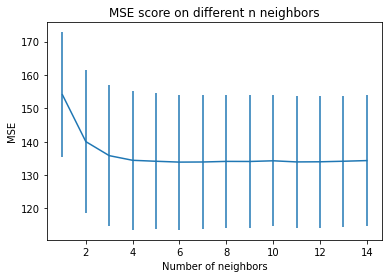

In [24]:
##
## Standardize X : 
##

standardizer = preprocessing.StandardScaler().fit(X)
X_std = standardizer.transform(X)
X_std = pd.DataFrame(X_std, columns= X.columns, index = X.index)

# ##
# ## Set the best number of neighbors
# ##

my_meth = KNNImputer
param_grid = {"n_neighbors" : np.arange(1,15,1)}
cv = 4

# res = missing_values_treatment.launch_my_pseudo_CV(X_std,my_meth,param_grid, cv = cv)
# # Save dictionnary of results : 
# import pickle
# with open(res_path+"set_n_KNN_impute"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

import pickle
with open(res_path+"set_n_KNN_impute"+".pkl", "rb") as f :
        res = pickle.load(f)

fig_name = "set_n_KNN_impute.jpg"
missing_values_treatment.plot_MSE_scores_KNN_impute(res, param_grid, fig_name)

In [25]:
## Impute missing values :
imputer = KNNImputer(n_neighbors=4)
pred_std = imputer.fit_transform(X_std)
pred_std = pd.DataFrame(pred_std, index = X.index, columns = X.columns)

## Inverse-standardize : 
# pred_std = pd.read_csv(res_path+"dataframe_std_KNN_impute.csv",index_col=0)
pred = standardizer.inverse_transform(pred_std)
pred = pd.DataFrame(pred, index = X.index, columns = X.columns)

## uncomment to add predicted values in data : 
# data.at[:,pred.columns.values]= pred

##### Separation des variables dans le permis de construire : 
En utilisant la description des variables données sur [ce site](https://www.splitgraph.com/seattle-gov/2018-building-energy-benchmarking-7rac-kyay), j'ai classé celles qui me semblaient être dans le permis de construction, et les variables liées à la consommation électrique. Je rappelle que j'ai faire le traitement des variables d'émission de CO2 au préalable.

In [26]:
var_in_building_permit = ['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'ZipCode',
                          'CouncilDistrictCode', 'Neighborhood', 'NumberofBuildings',
                          'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
                          'PropertyGFABuilding(s)', 'LargestPropertyUseType',
                          'age_of_building','ComplianceStatus']

CO2_var = ['CO2_emissions','CO2_emissions_intensity']

energy_var = ['SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)',
              'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
              'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
              'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 
              'NaturalGas(therms)','NaturalGas(kBtu)']


## Analyse univariée :

#### Données numériques : 

L'histogramme sur la plupart des variables numériques ne permettait pas de distinguer la répartition des données. Je passe en échelle logarithmique pour voir s'il on arrive mieux à distinguer la distribution avec cette transformation. La première étape pour cela est de retirer les valeurs négatives, qui sont présentes dans certaines variables :

In [27]:
num_data_positive = data[numerical_var_in_data].drop(["ENERGYSTARScore", "age_of_building", "NumberofFloors"], axis = 1)
num_data_positive[num_data_positive<0]= np.nan
num_data_log = np.log(num_data_positive+1)

Variables de description :


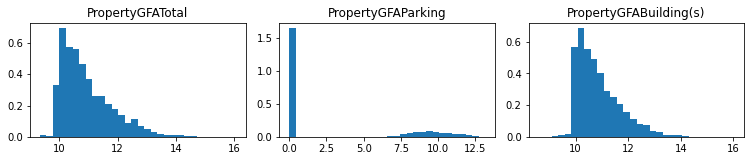

In [28]:
print("Variables de description :")
univariate_analysis.plot_multi_hist(num_data_log, var_in_building_permit, figsize=(14,8))

Pour rappel, "GFA" fait référence à la surface au rez-de-chaussée. Ainsi, le log de la surface au sol des immeubles a l'air de suivre une loi à peu près normale, et une partie importante d'immeuble n'a pas de surface de parking.

Variables énegétiques :


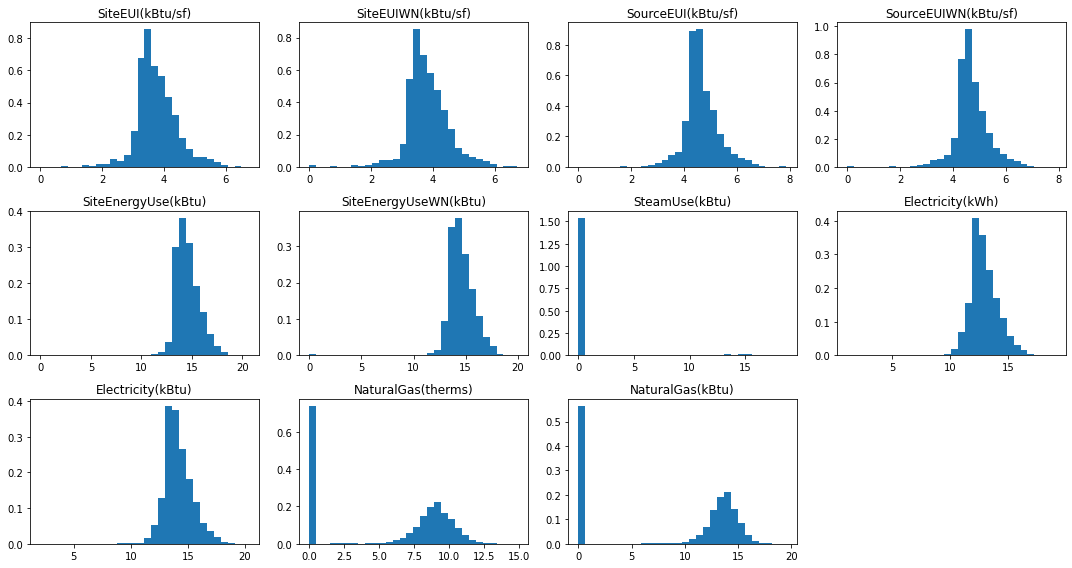

In [29]:
print("Variables énegétiques :")
univariate_analysis.plot_multi_hist(num_data_log, energy_var, figsize=(15,8))

Les variables liées à la consommation électrique ont l'air de suivre des lois normales, bien que la variance a l'air petite, et les queues de distribution assez lourdes. Les variables de consommation de gaz sont la somme d'une distribution de dirac en 0 et d'une loi normale.  

Variable émission CO2


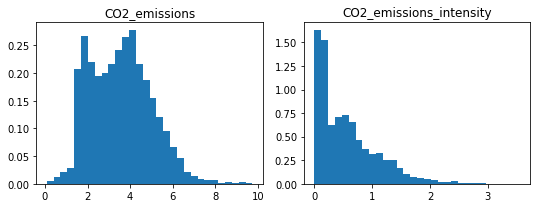

In [30]:
print("Variable émission CO2")
univariate_analysis.plot_multi_hist(num_data_log, CO2_var, figsize=(15,3))

Les variables liées à l'émission de CO2 ont l'air d'être la somme de deux distributions : une première avec une variance et moyenne petites, et une deuxième une peu plus grande (correspondant à la deuxième bosse sur la droite)
<!-- ##TODO : description à compléter -->


##### Variables fortement correlées : 

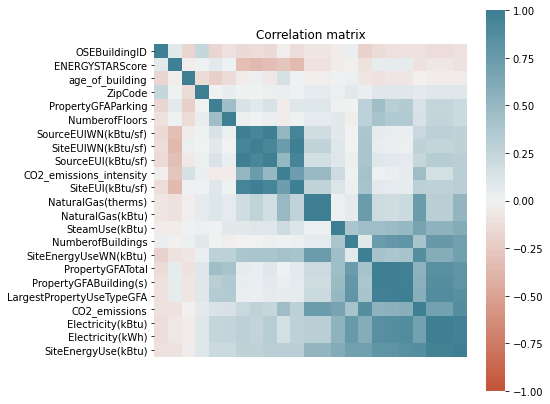

In [31]:
corr_matrix = data.corr()
corr_matrix=corr_matrix.sort_values(by="SiteEnergyUse(kBtu)", ascending = True)
corr_matrix=corr_matrix.sort_values(by="SiteEnergyUse(kBtu)", ascending = True, axis = 1)

fig, ax = plt.subplots(figsize=(7,7))    
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels=False
)
# ax.tick_params(bottom=False)
ax.set_title("Correlation matrix")
plt.show()

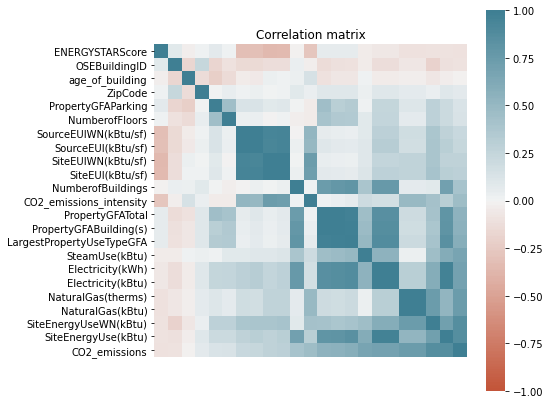

In [32]:
corr_matrix = data.corr()
corr_matrix=corr_matrix.sort_values(by="CO2_emissions", ascending = True)
corr_matrix=corr_matrix.sort_values(by="CO2_emissions", ascending = True, axis = 1)

fig, ax = plt.subplots(figsize=(7,7))    
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels=False
)
# ax.tick_params(bottom=False)
ax.set_title("Correlation matrix")
plt.show()

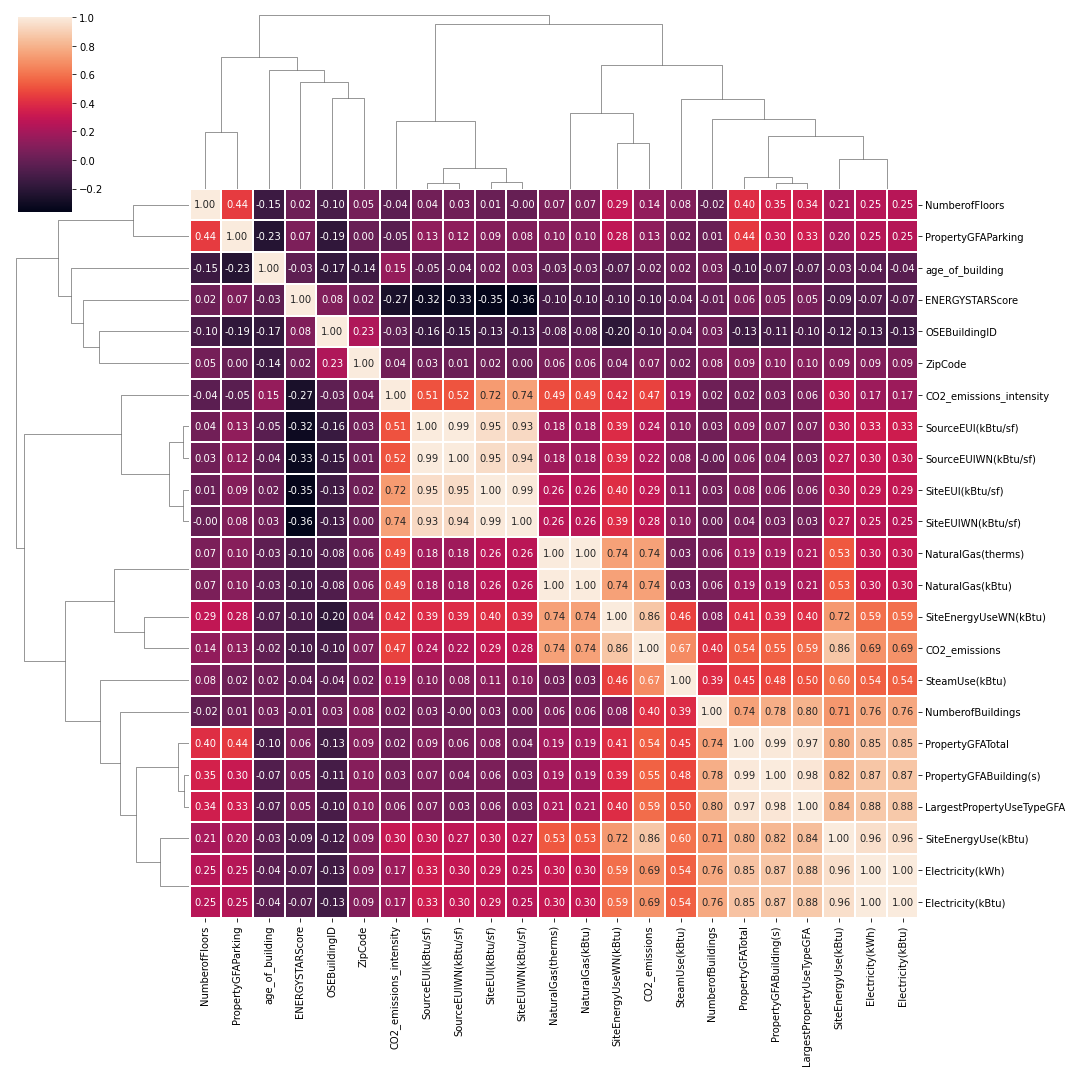

In [33]:
sns.clustermap(data.corr(), annot=True, linewidths=0.1, fmt='.2f', figsize=(15, 15))
plt.show()

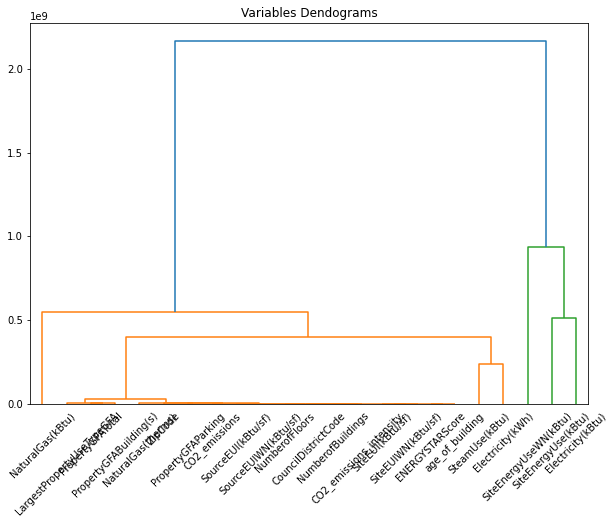

In [45]:
# from sklearn.cluster import AgglomerativeClustering

# cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
# cluster.fit_predict(pred.transpose())

#####################################
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Variables Dendograms")
dend = shc.dendrogram(shc.linkage(pred.transpose(), method='ward'),labels = pred.columns)

# pd.DataFrame(nan_euclidean_distances(row_values),
#                                   columns=row_index, index = row_index)
# Z = linkage(data, "weighted")
# clustering = pd.Series(fcluster(Z, t=threshold_clustering), index = data.columns)

In [44]:
help(shc.dendrogram)

Help on function dendrogram in module scipy.cluster.hierarchy:

dendrogram(Z, p=30, truncate_mode=None, color_threshold=None, get_leaves=True, orientation='top', labels=None, count_sort=False, distance_sort=False, show_leaf_counts=True, no_plot=False, no_labels=False, leaf_font_size=None, leaf_rotation=None, leaf_label_func=None, show_contracted=False, link_color_func=None, ax=None, above_threshold_color='C0')
    Plot the hierarchical clustering as a dendrogram.
    
    The dendrogram illustrates how each cluster is
    composed by drawing a U-shaped link between a non-singleton
    cluster and its children. The top of the U-link indicates a
    cluster merge. The two legs of the U-link indicate which clusters
    were merged. The length of the two legs of the U-link represents
    the distance between the child clusters. It is also the
    cophenetic distance between original observations in the two
    children clusters.
    
    Parameters
    ----------
    Z : ndarray
        Th

##### Retrait des bâtiments sans le score : 

In [101]:
# index_to_drop = data[data["ENERGYSTARScore"].isna().values].index
# data = data.drop(index_to_drop,axis=0)

# X = data[float_var]
# X_pred = pred.drop(index_to_drop,axis=0)
# y = data["ENERGYSTARScore"]

## Etude de la variable de réponse 

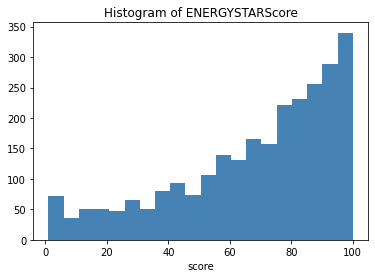

count    2656.000000
mean       68.116717
std        26.377049
min         1.000000
25%        52.500000
50%        75.500000
75%        89.625000
max       100.000000
Name: ENERGYSTARScore, dtype: float64

In [102]:
import univariate_analysis
univariate_analysis.plot_hist_y(y)
y.describe()

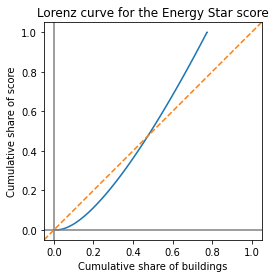

gini = nan
AUC = nan


In [103]:
univariate_analysis.plot_lorenz_curve(y)

In [ ]:
new_data = pd.read_csv(data_path+"2016-building-energy-benchmarking.csv", 
                          low_memory=False)#, index_col=0)
new_data = new_data.rename(columns={"Zip Codes":"ZipCode","Comment":"Comments",
                                    "TotalGHGEmissions": "total_2016", 
                                    "GHGEmissionsIntensity":"intensity_2016",
                                    "GHGEmissions(MetricTonsCO2e)":"CO2_2015" ,
                                    "GHGEmissionsIntensity(kgCO2e/ft2)":"CO2_intensity_2015"})

### remove non-pertinent columns : 
new_data = new_data.drop(["Location", '2010 Census Tracts', 'City Council Districts'], axis=1)